In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

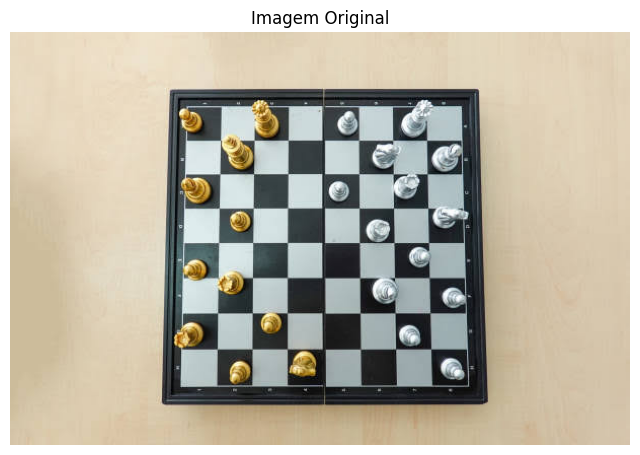

In [45]:
imagem = cv2.imread("board1.png")
imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

# Mostrar imagem original
plt.figure(figsize=(8, 8))
plt.title("Imagem Original")
plt.imshow(imagem_rgb)
plt.axis("off")
plt.show()

In [46]:
cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
borrada = cv2.GaussianBlur(cinza, (5, 5), 0)

# Detectar bordas com Canny
bordas = cv2.Canny(borrada, 50, 150)

# Encontrar contornos
contornos, _ = cv2.findContours(bordas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Procurar o maior quadrilátero
contorno_tabuleiro = None
maior_area = 0

for contorno in contornos:
    perimetro = cv2.arcLength(contorno, True)
    aprox = cv2.approxPolyDP(contorno, 0.02 * perimetro, True)
    
    if len(aprox) == 4:
        area = cv2.contourArea(aprox)
        if area > maior_area:
            maior_area = area
            contorno_tabuleiro = aprox

# Mostrar erro se nada for encontrado
if contorno_tabuleiro is None:
    raise Exception("Tabuleiro não encontrado na imagem.")

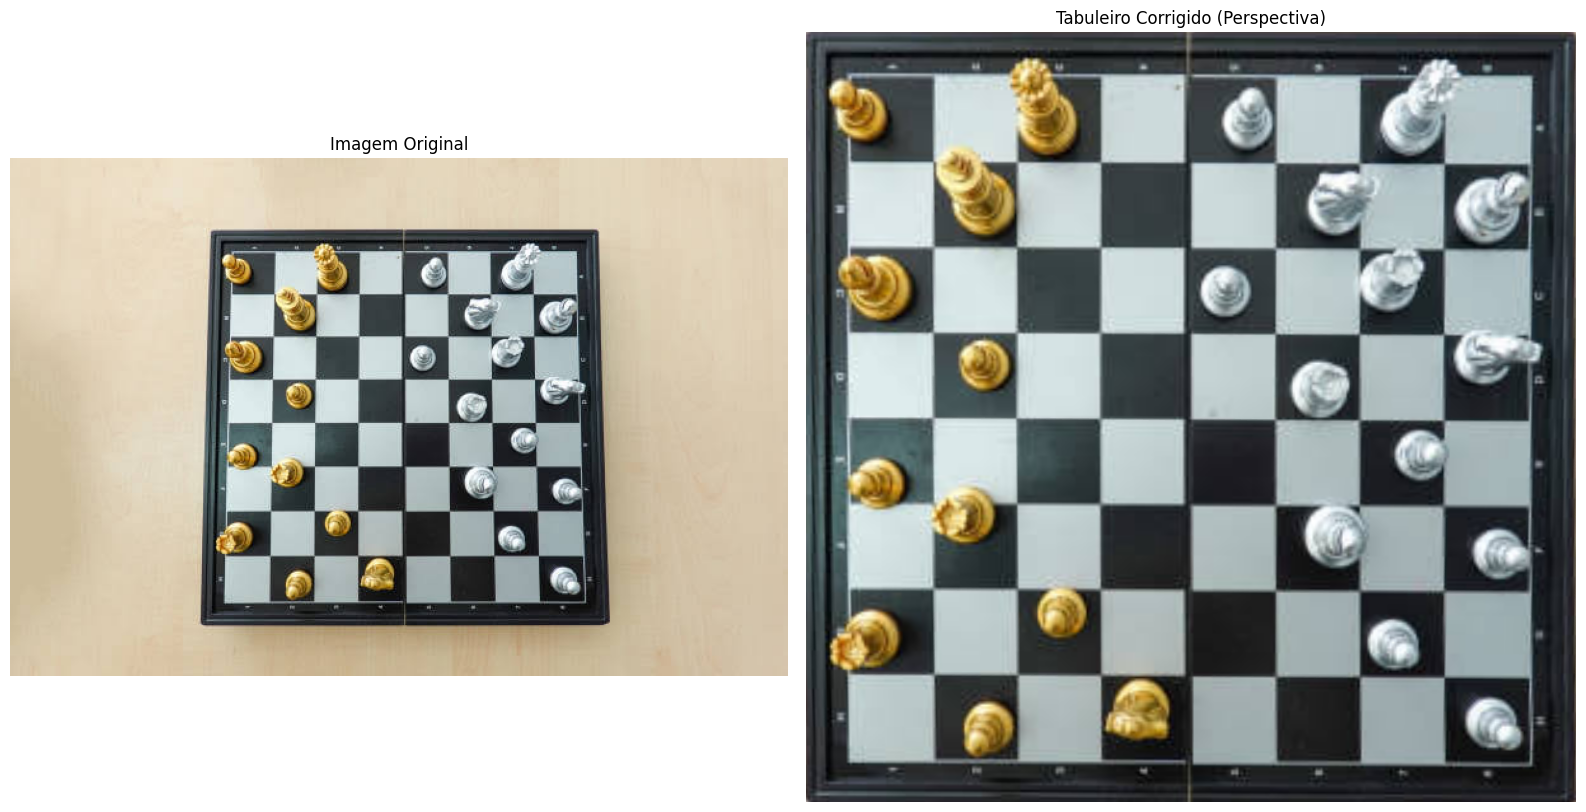

In [48]:
# Ordenar os pontos do contorno
def ordenar_pontos(pontos):
    pontos = pontos.reshape(4, 2)
    soma = pontos.sum(axis=1)
    diff = np.diff(pontos, axis=1)

    topo_esq = pontos[np.argmin(soma)]
    baixo_dir = pontos[np.argmax(soma)]
    topo_dir = pontos[np.argmin(diff)]
    baixo_esq = pontos[np.argmax(diff)]

    return np.array([topo_esq, topo_dir, baixo_dir, baixo_esq], dtype="float32")

# Aplicar warp perspective
pontos_ordenados = ordenar_pontos(contorno_tabuleiro)
largura = altura = 800

pontos_destino = np.array([
    [0, 0],
    [largura - 1, 0],
    [largura - 1, altura - 1],
    [0, altura - 1]
], dtype="float32")

matriz = cv2.getPerspectiveTransform(pontos_ordenados, pontos_destino)
warp = cv2.warpPerspective(imagem, matriz, (largura, altura))
warp_rgb = cv2.cvtColor(warp, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16, 8))

# Imagem original
plt.subplot(1, 2, 1)
plt.title("Imagem Original")
plt.imshow(imagem_rgb)
plt.axis("off")

# Imagem corrigida
plt.subplot(1, 2, 2)
plt.title("Tabuleiro Corrigido (Perspectiva)")
plt.imshow(warp_rgb)
plt.axis("off")

plt.tight_layout()
plt.show()
